# Benchmarks

Ji, Shaolin, Shige Peng, Ying Peng, and Xichuan Zhang. “Three Algorithms for Solving High-Dimensional Fully-Coupled FBSDEs through Deep Learning.” ArXiv:1907.05327 [Cs, Math], February 2, 2020. http://arxiv.org/abs/1907.05327.

# Setup

Consider

$$
\newcommand{\R}{\mathbb R}
W \in \R ^m, N \in \R^\ell\\
X\in \R^d, Y\in \R^n, Z\in \R^{n\times m}, R \in \R ^{n\times \ell}\\
\gamma \in \R^{d \times \ell}, \sigma \in \R^{d\times m} \\
f\in C^2(\R^d, E\subset\R^n)\\
$$

For the control problem with jumps, we would have the FBSDE of the form (assuming zero drift on $X$)

$$
\begin{aligned}
dX_t &= \sigma_t dW_t + \gamma_t dN_t\\
dY_t &= (\dots)dt + Z_t dW_t + R_t dN_t
\end{aligned}
$$

Assume that $Y=f(X)$. Necessarily, by Ito's lemma (Oksendal, p.9, 1.2.8; for k-th column):

$$
\begin{aligned}
Z_t &= (D f(X_t))^T \cdot \sigma_t \\
R^{(\cdot k)}_t &= f\left(X_t+\gamma ^{(\cdot k)}_t\right) - f(X_t)
\end{aligned}
$$

Assuming that $D f(X) D f(X)^T$ is never singular and $f^{-1}\in C^2(E, \R^d)$ exists, we have

$$
\begin{aligned}
\sigma_t &= \left(D f(X_t) D f(X_t) ^T \right) ^{-1} D f(X_t) Z =: \beta(X_t) Z_t\\
\gamma^{(\cdot k)}_t &= f^{-1}\left(f(X_t) + R^{(\cdot k)}\right) - X_t
\end{aligned}
$$

for $\beta(X) = \left(D f(X) D f(X) ^T \right) ^{-1} D f(X)$. Thus we obtain by Ito's lemma (note that $D^2 f$ is a 3d-tensor indexed by $i,j,k$ with $k\in 1,\dots, n$)

$$
(\dots)dt = \frac 12 \sum_{i,j=1}^d (\beta(X_t) Z_t(\beta(X_t) Z_t)^T)^{(ij)} (D^2 f(X_t))^{(ij)} dt
$$

Altogether, we can rewrite

$$
\begin{aligned}
dX_t &= \beta(X_t) Z_t dW_t + \left(f^{-1}\left(f(X_t) + R^{(\cdot k)}\right) - X_t\right) dN_t\\
dY_t &= \frac 12 \sum_{i,j=1}^d (\beta(X_t) Z_t(\beta(X_t) Z_t)^T)^{(ij)} (D^2 f(X_t))^{(ij)} dt + Z_t dW_t + R_t dN_t
\end{aligned}
$$

# Example 1

Consider $d=\ell=m=n$ and $f(X) = g(X) = \exp(X)$, elementwise. Then

$$
\begin{aligned}
f^{-1}(X) &= \log(X)\\
Df(X)^{(ij)} &= \delta_{ij} \exp(X^{(i)}) =\operatorname{diag}(\exp(X))\\
D^2 f(X)^{(ijk)} &= \delta_{ijk} \exp(X^{(i)})\\
\beta(X) &= \delta_{ij}\exp(-X^{(i)}) = \operatorname{diag}(\exp(-X))
\end{aligned}
$$

Thus, the system can be rewritten (drift of dY is k-valued vector, $\operatorname{diag}$ means extracting diagonal, or converting vector into diagonal matrix depending on the context):

$$
\begin{aligned}
dX_t &= \operatorname{diag}(\exp(-X)) Z_t dW_t + \left(\log\left(\exp(X_t) + R^{(\cdot k)}\right) - X_t\right) dN_t\\
dY_t &= \frac 12 \operatorname{diag} ( \operatorname{diag}(\exp(-X)) Z_t( \operatorname{diag}(\exp(-X)) Z_t)^T) \exp(X_t) dt + Z_t dW_t + R_t dN_t
\end{aligned}
$$

Thus the solution is given by $Y_t = \exp(X_t)$.

# Example 1a

Consider $d=\ell=m=n$ and $f(X) = g(X) = \exp(aX)$, elementwise. Then

$$
\begin{aligned}
f^{-1}(X) &= \frac 1a \log(X)\\
Df(X)^{(ij)} &= a\delta_{ij} \exp(aX^{(i)}) = a\operatorname{diag}(\exp(aX))\\
D^2 f(X)^{(ijk)} &= a^2 \delta_{ijk} \exp(aX^{(i)})\\
\beta(X) &= \frac 1a \delta_{ij}\exp(-aX^{(i)}) = \frac 1a \operatorname{diag}(\exp(-aX))
\end{aligned}
$$

Thus, the system can be rewritten (drift of dY is k-valued vector, $\operatorname{diag}$ means extracting diagonal, or converting vector into diagonal matrix depending on the context):

$$
\begin{aligned}
dX_t &= \frac 1a \operatorname{diag}(\exp(-aX)) Z_t dW_t + \left(\frac 1a \log\left(\exp(aX_t) + R^{(\cdot k)}\right) - X_t\right) dN_t\\
dY_t &= \frac {1}{2} \operatorname{diag} ( \operatorname{diag}(\exp(-aX)) Z_t( \operatorname{diag}(\exp(-aX)) Z_t)^T) \exp(aX_t) dt + Z_t dW_t + R_t dN_t
\end{aligned}
$$

Thus the solution is given by $Y_t = \exp(aX_t)$.

# Implementation

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Reshape, concatenate, Layer, BatchNormalization, Add
from keras import Model, initializers
from keras.callbacks import ModelCheckpoint
from keras.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from keras.metrics import mse
from keras.optimizers import Adam
from keras.callbacks import Callback
import pandas as pd
from tqdm import tqdm
from itertools import product
import shutil

2022-11-17 15:02:01.560881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 15:02:01.665740: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-17 15:02:01.698842: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 15:02:02.257262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import os
from gpu_utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = str(pick_gpu_lowest_memory())

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [4]:
np.set_printoptions(edgeitems=11, linewidth=90, formatter=dict(float=lambda x: "%7.5g" % x))

In [15]:
# create dirs
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"{timestamp}"
tb_log_dir = "/home/tmp/starokon/tensorboard/" + model_name
output_dir = f"_output/models/{model_name}"
os.makedirs(output_dir, exist_ok=True)

# Inputs

In [136]:
# model parameters
n_paths = 2 ** 14
n_timesteps = 16
time_horizon = 1.
n_x_dimensions = 20
n_y_dimensions = 20
n_diffusion_factors = 20
n_jump_factors = 20
intensity = 5.
alpha = 4.
stddev = 1e-2

In [137]:
# # model parameters
# n_paths = 2 ** 12
# n_timesteps = 4
# time_horizon = 1.
# n_x_dimensions = 2
# n_y_dimensions = 2
# n_diffusion_factors = 2
# n_jump_factors = 2
# intensity = 5.
# alpha = 4.
# stddev = 1e-2

In [138]:
dt = time_horizon / n_timesteps

In [139]:
def b(t, x, y, z, r):
    return tf.zeros((n_x_dimensions,))

def s(t, x, y, z, r):
    return tf.linalg.matmul(tf.linalg.diag(tf.exp(-alpha * x)), z) / alpha

def v(t, x, y, z, r):
    # floor the log argument
    res = tf.maximum(tf.exp(alpha * x) + r, 1e-2)
    return (tf.math.log(res) / alpha - x)

def f(t, x, y, z, r):
    res = tf.linalg.matmul(tf.linalg.diag(tf.exp(-alpha * x)), z)
    return 0.5 * tf.einsum('ij,j', tf.linalg.matmul(res, res, transpose_b=True), tf.exp(alpha * x))

def g(x):
    return tf.exp(x)


# Custom layers and callbacks

In [140]:
class InitialValue(Layer):
    
    def __init__(self, y0, **kwargs):
        super().__init__(**kwargs)
        self.y0 = y0
    
    def call(self, inputs):
        return self.y0


In [141]:
class Y0Callback(Callback):
    
    def __init__(self, filepath=None, freq=32):
        super(Y0Callback, self).__init__()
        self.filepath = filepath
        self.batch = 1
        self.freq = freq
        self.y0s = np.zeros((0, n_y_dimensions))
    
    def on_batch_end(self, epoch, logs=None):
        y0 = self.model.get_layer('y_0').y0.numpy()
        self.y0s = np.append(self.y0s, y0, axis=0)
        if self.batch % self.freq == 0:
            print(f"\n{y0}\n")
        self.batch += 1

    def on_epoch_end(self, *args, **kwargs):
        self.batch = 1
        
#     def on_train_end(self, logs=None):
#         if self.filepath is not None:
#             pd.DataFrame(self.y0s).to_csv(self.filepath)

In [142]:
class BatchSave(Callback):
    def __init__(self, directory):
        self.batch = 1
        self.epoch = 1
        self.directory = directory
        shutil.rmtree(directory, ignore_errors=True)
        os.makedirs(directory, exist_ok=True)
        
    def on_epoch_end(self, *args, **kwargs):
        self.epoch += 1
        self.batch = 1

    def on_batch_begin(self, batch, logs={}):
        filename = os.path.join(self.directory, f"weights_{self.epoch:03}_{self.batch:03}.h5")
        self.model.save_weights(filename)
        self.batch += 1

# Model

In [143]:
def build_model(n_x_dimensions, n_y_dimensions, n_diffusion_factors, n_jump_factors, n_timesteps, time_horizon):

    dt = time_horizon / n_timesteps

    def dX(t, x, y, z, r, dW, dN):

        def drift(arg):
            x, y, z, r = arg
            return tf.math.multiply(b(t, x, y, z, r), dt)
        a0 = tf.vectorized_map(drift, (x, y, z, r))

        def noise(arg):
            x, y, z, r, dW = arg
            return tf.einsum('ij,j', s(t, x, y, z, r), dW)
        a1 = tf.vectorized_map(noise, (x, y, z, r, dW))

        def jump(arg):
            x, y, z, r, dN = arg
            return tf.einsum('ij,j', v(t, x, y, z, r), dN)
        a2 = tf.vectorized_map(jump, (x, y, z, r, dN))

        return a0 + a1 + a2

    def dY(t, x, y, z, r, dW, dN):

        def drift(arg):
            x, y, z, r = arg
            return tf.math.multiply(f(t, x, y, z, r), dt)
        a0 = tf.vectorized_map(drift, (x, y, z, r))

        def noise(arg):
            x, y, z, r, dW = arg
            return tf.einsum('ij,j', z, dW)
        a1 = tf.vectorized_map(noise, (x, y, z, r, dW))

        def jump(arg):
            x, y, z, r, dN = arg
            return tf.einsum('ij,j', r, dN)
        a2 = tf.vectorized_map(jump, (x, y, z, r, dN))        

        return a0 + a1 + a2

    @tf.function
    def hx(args):
        i, x, y, z, r, dW, dN = args
        return x + dX(i * dt, x, y, z, r, dW, dN)

    @tf.function
    def hy(args):
        i, x, y, z, r, dW, dN = args
        return y + dY(i * dt, x, y, z, r, dW, dN)

    paths = []

    #n_hidden_units = n_x_dimensions + n_diffusion_factors + n_jump_factors + 10
    n_hidden_units = 5

    inputs_x0 = Input(shape=(n_x_dimensions))
    inputs_dW = Input(shape=(n_timesteps, n_diffusion_factors))
    inputs_dN = Input(shape=(n_timesteps, n_jump_factors))

    # constant x0

    x0 = tf.Variable([[1. for _ in range(n_x_dimensions)]], trainable=False)
    y0 = tf.Variable([[0. for _ in range(n_y_dimensions)]], trainable=True)

    x = InitialValue(x0, trainable=False, name='x_0')(inputs_dW)
    y = InitialValue(y0, trainable=True, name='y_0')(inputs_dW)

    # adjoints

    z = concatenate([x, y])
    z = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddev), name='z1_0')(z)
    z = Dense(n_y_dimensions * n_diffusion_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddev), name='z2_0')(z)
    z = BatchNormalization(name='zbn_0')(z)
    z = Reshape((n_y_dimensions, n_diffusion_factors), name='zr_0')(z)

    r = concatenate([x, y])
    r = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddev), name='r1_0')(r)
    r = Dense(n_y_dimensions * n_jump_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddev), name='r2_0')(r)
    r = BatchNormalization(name='rbn_0')(r)
    r = Reshape((n_y_dimensions, n_jump_factors), name='rr_0')(r)

    paths += [[x, y, z, r]]

    # pre-compile lambda layers
    
    for i in range(n_timesteps):

        step = InitialValue(tf.Variable(i, dtype=tf.float32, trainable=False))(inputs_dW)

        dW = Lambda(lambda x: x[0][:, tf.cast(x[1], tf.int32)])([inputs_dW, step])
        dN = Lambda(lambda x: x[0][:, tf.cast(x[1], tf.int32)])([inputs_dN, step])

        x, y = (
            Lambda(hx, name=f'x_{i+1}')([step, x, y, z, r, dW, dN]),
            Lambda(hy, name=f'y_{i+1}')([step, x, y, z, r, dW, dN]),
        )

        # we don't train z for the last time step; keep for consistency
        z = concatenate([x, y])
        z = Dense(n_hidden_units, activation='relu', name=f'z1_{i+1}')(z)
        z = Dense(n_y_dimensions * n_diffusion_factors, activation='relu', name=f'z2_{i+1}')(z)
        z = Reshape((n_y_dimensions, n_diffusion_factors), name=f'zr_{i+1}')(z)
        z = BatchNormalization(name=f'zbn_{i+1}')(z)

        # we don't train r for the last time step; keep for consistency
        r = concatenate([x, y])
        r = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddev), name=f'r1_{i+1}')(r)
        r = Dense(n_y_dimensions * n_jump_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=stddev), name=f'r2_{i+1}')(r)
        r = Reshape((n_y_dimensions, n_jump_factors), name=f'rr_{i+1}')(r)
        r = BatchNormalization(name=f'rbn_{i+1}')(r)

        paths += [[x, y, z, r]]

    outputs_loss = Lambda(lambda r: r[1] - tf.vectorized_map(g, r[0]))([x, y])
    
    # remember that z and r are matrices
    outputs_paths = tf.stack(
        [tf.stack([p[0] for p in paths[1:]], axis=1)] + 
        [tf.stack([p[1] for p in paths[1:]], axis=1)] + 
        [tf.stack([p[2][:, :, i] for p in paths[1:]], axis=1) for i in range(n_diffusion_factors)] +
        [tf.stack([p[3][:, :, i] for p in paths[1:]], axis=1) for i in range(n_jump_factors)], axis=2)

    model_loss = Model([inputs_x0, inputs_dW, inputs_dN], outputs_loss)

    # (n_sample, n_timestep, x/y/z_k, n_dimension)
    # skips the first time step
    model_paths = Model([inputs_x0, inputs_dW, inputs_dN], outputs_paths)

    return model_loss, model_paths


In [144]:
# create model
dt = time_horizon / n_timesteps
model_loss, model_paths = build_model(n_x_dimensions=n_x_dimensions,
                                      n_y_dimensions=n_y_dimensions,
                                      n_diffusion_factors=n_diffusion_factors,
                                      n_jump_factors=n_jump_factors,
                                      n_timesteps=n_timesteps,
                                      time_horizon=time_horizon)


In [145]:
model_loss.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 16, 20)]     0           []                               
                                                                                                  
 x_0 (InitialValue)             (1, 20)              20          ['input_26[0][0]']               
                                                                                                  
 y_0 (InitialValue)             (1, 20)              20          ['input_26[0][0]']               
                                                                                                  
 concatenate_152 (Concatenate)  (1, 40)              0           ['x_0[0][0]',                    
                                                                  'y_0[0][0]']             

# Training

In [146]:
x0 = tf.constant(np.full((n_paths, n_x_dimensions), 1.), dtype=tf.float32)
dW = tf.sqrt(dt) * tf.random.normal((n_paths, n_timesteps, n_diffusion_factors))
dN = tf.random.poisson((n_paths, n_timesteps), tf.constant(dt * np.array([intensity for _ in range(n_jump_factors)])))
target = tf.zeros((n_paths, n_y_dimensions))

In [147]:
callbacks = []

# define callbacks
y0_callback = Y0Callback(os.path.join(output_dir, "y0.csv"))
callbacks += [y0_callback]
# callbacks += [BatchSave(os.path.join(output_dir, "weights"))]
callbacks += [ModelCheckpoint(os.path.join(output_dir, "model.h5"), monitor="loss", save_weights_only=True, save_best_only=True, overwrite=True)]
callbacks += [tf.keras.callbacks.TerminateOnNaN()]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-4, patience=30)]


In [148]:
def mse_loss(y_true, y_pred):
    # print("\n", y_pred.numpy().flatten(), "\r")
    return(tf.keras.metrics.mean_squared_error(y_true, y_pred))

adam = Adam(learning_rate=1e-2) 
model_loss.compile(loss=mse_loss, optimizer=adam, run_eagerly=True)

In [ ]:
history = model_loss.fit([x0, dW, dN], target, batch_size=32, initial_epoch=0, epochs=20, callbacks=callbacks, shuffle=False)
df_loss = pd.DataFrame(history.history['loss'])
df_loss.to_csv(os.path.join(output_dir, 'loss.csv'))


Epoch 1/20
The following Variables were used a Lambda layer's call (x_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 20) dtype=float32, numpy=
array([[      0,       0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,       0,
              0,       0]], dtype=float32)>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (y_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 20) dtype=float32, numpy=
array([[      0,       0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,       0,
              0,       0]], dtype=float32)>
It is 

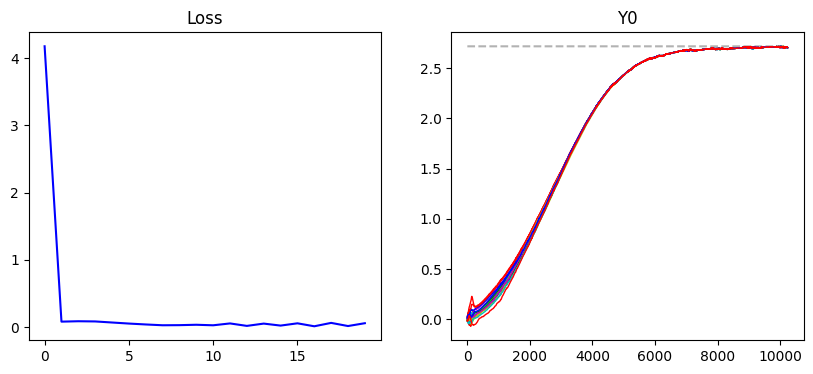

In [169]:
colors = 'b', 'r', 'g', 'y', 'm', 'c'
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(history.history['loss'], c='b')
ax[0].set_title('Loss')
ax[1].plot(np.arange(y0_callback.y0s.shape[0]), np.exp(1) * np.ones((y0_callback.y0s.shape[0],)), c='k', alpha=0.3, linestyle='dashed')

ax[1].set_title('Y0')
for i in np.arange(y0_callback.y0s.shape[1]):
    ax[1].plot(y0_callback.y0s[:, i], c=colors[i%len(colors)], linewidth=1)
fig.savefig('FBSDE20.png')

# Comments

* Alpha has to grow with number of dimensions to avoid explosion
* Number of samples has to grow with number of dimensions to converge to Y_0, loss will be close to zero if the number of samples is too small. What is a good number of samples?
* Too little samples leads to plain memorizing overfitting. Could this be a theorem? Maybe reduce the size of the neural net to avoid overfitting, it's overparameterized? Can we quantify overfitting?
* Perhaps come up with another example with closed solution that satisfies monotonicity property